In [1]:
from PIL import Image
import cv2
import numpy as np
from matplotlib import cm
import matplotlib.pyplot as plt
%matplotlib inline

import torch

In [2]:
!git clone https://github.com/gymoon10/utils

Cloning into 'utils'...
remote: Enumerating objects: 14, done.
remote: Counting objects: 100% (14/14), done.
remote: Compressing objects: 100% (12/12), done.
remote: Total 14 (delta 1), reused 0 (delta 0), pack-reused 0
Unpacking objects: 100% (14/14), done.


In [4]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [5]:
from utils.openpose_net import OpenPoseNet

net = OpenPoseNet()

# 학습된 가중치 load
net_weights = torch.load('/content/drive/My Drive/pose_model_scratch.pth', map_location={'cuda0' : 'cpu'})
keys = list(net_weights.keys())

# 로드한 파라미터를 구축한 모델의 파라미터명인 net.state_dict().keys()로 복사
# 학습된 모델과 구축한 모델의 네트워크 계층 이름이 다르기 때문에 대응시켜 load
weights_load = {}
for i in range(len(keys)):
    weights_load[list(net.state_dict().keys())[i]] = net_weights[list(keys)[i]]

# 복사한 내용을 구축한 모델에 반영
state = net.state_dict()
state.update(weights_load)
net.load_state_dict(state)

<All keys matched successfully>

In [7]:
print(keys[:10])

['module.model0.0.weight', 'module.model0.0.bias', 'module.model0.2.weight', 'module.model0.2.bias', 'module.model0.5.weight', 'module.model0.5.bias', 'module.model0.7.weight', 'module.model0.7.bias', 'module.model0.10.weight', 'module.model0.10.bias']


In [10]:
net_weights['module.model0.0.weight']

tensor([[[[-3.0816e-02, -2.7150e-02, -3.0621e-02],
          [ 3.5404e-02,  4.7821e-02,  9.8836e-03],
          [ 2.2803e-02, -3.4138e-03, -1.2883e-02]],

         [[ 1.2511e-02,  6.5368e-02,  2.2626e-02],
          [ 1.4461e-01,  2.5544e-01,  1.5734e-01],
          [ 7.6110e-02,  1.7890e-01,  4.4371e-02]],

         [[-8.6022e-03,  8.4912e-02,  5.9001e-02],
          [ 6.5320e-02,  1.8468e-01,  8.0516e-02],
          [-5.4226e-02,  2.7868e-02, -8.9824e-02]]],


        [[[ 3.0306e-01, -4.0521e-01, -6.7586e-01],
          [ 5.8763e-01, -3.1917e-01, -6.7281e-01],
          [ 7.9722e-01,  5.7288e-01, -1.3060e-01]],

         [[ 2.6631e-01, -4.0472e-01, -5.7804e-01],
          [ 4.7226e-01, -3.0042e-01, -5.6161e-01],
          [ 6.3262e-01,  5.7064e-01, -1.3816e-01]],

         [[-1.5612e-02, -9.4785e-02, -5.4440e-02],
          [ 6.4247e-02, -1.4478e-01, -1.0454e-01],
          [ 1.1166e-01,  2.3931e-01,  1.3067e-02]]],


        [[[ 1.4906e-02,  1.7526e-01,  2.9406e-02],
          [ 1.7

In [16]:
!pip install opencv-python

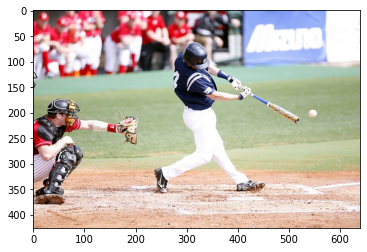

In [18]:
test_image = '/content/hit-1407826_640.jpg'
oriImg = cv2.imread(test_image)  
oriImg = cv2.cvtColor(oriImg, cv2.COLOR_BGR2RGB)
plt.imshow(oriImg)
plt.show()

size = (368, 368)
img = cv2.resize(oriImg, size, interpolation=cv2.INTER_CUBIC)
img = img.astype(np.float32) / 255.

color_mean = [0.485, 0.456, 0.406]
color_std = [0.229, 0.224, 0.225]

preprocessed_img = img.copy()[:, :, ::-1]  # BGR→RGB

for i in range(3):
    preprocessed_img[:, :, i] = preprocessed_img[:, :, i] - color_mean[i]
    preprocessed_img[:, :, i] = preprocessed_img[:, :, i] / color_std[i]

# (높이, 폭, 색) → (색, 높이, 폭)
img = preprocessed_img.transpose((2, 0, 1)).astype(np.float32)
img = torch.from_numpy(img)

x = img.unsqueeze(0)

In [23]:
net.eval()
predicted_outputs, _ = net(x)  # (out6_1 - PAF, out6_2 - Heatmap), saved_for_loss

# tensor (c, h, w) -> numpy (h, w, c)
pafs = predicted_outputs[0][0].detach().numpy().transpose(1, 2, 0)
heatmaps = predicted_outputs[1][0].detach().numpy().transpose(1, 2, 0)

pafs = cv2.resize(pafs, size, interpolation=cv2.INTER_CUBIC)
heatmaps = cv2.resize(heatmaps, size, interpolation=cv2.INTER_CUBIC)

# 원본 이미지 사이즈로 확대
pafs = cv2.resize(
    pafs, (oriImg.shape[1], oriImg.shape[0]), interpolation=cv2.INTER_CUBIC)
heatmaps = cv2.resize(
    heatmaps, (oriImg.shape[1], oriImg.shape[0]), interpolation=cv2.INTER_CUBIC)

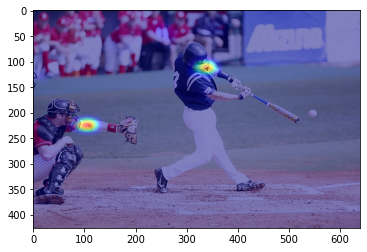

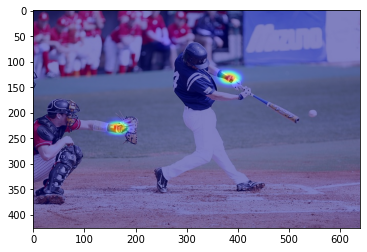

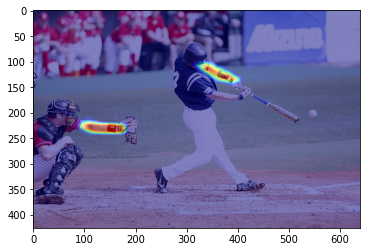

In [25]:
heat_map = heatmaps[:, :, 6]  # 6 : 왼쪽 팔꿈치
heat_map = Image.fromarray(np.uint8(cm.jet(heat_map)*255))
heat_map = np.asarray(heat_map.convert('RGB'))

blend_img = cv2.addWeighted(oriImg, 0.5, heat_map, 0.5, 0)
plt.imshow(blend_img)
plt.show()

heat_map = heatmaps[:, :, 7]  # 7 : 왼쪽 손목
heat_map = Image.fromarray(np.uint8(cm.jet(heat_map)*255))
heat_map = np.asarray(heat_map.convert('RGB'))

blend_img = cv2.addWeighted(oriImg, 0.5, heat_map, 0.5, 0)
plt.imshow(blend_img)
plt.show()

# 왼쪽 팔꿈치와 손목을 잇는 PAF의 x축 벡터
paf = pafs[:, :, 24]
paf = Image.fromarray(np.uint8(cm.jet(paf)*255))
paf = np.asarray(paf.convert('RGB'))

blend_img = cv2.addWeighted(oriImg, 0.5, paf, 0.5, 0)
plt.imshow(blend_img)
plt.show()

In [26]:
from utils.decode_pose import decode_pose

# PAF, heatmap을 이용해 인물의 각 부위를 연결하는 링크 구하기
# 추정한 pose를 덮어쓴 이미지 출력
_, result_img, _, _ = decode_pose(oriImg, heatmaps, pafs)

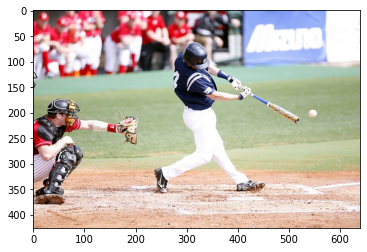

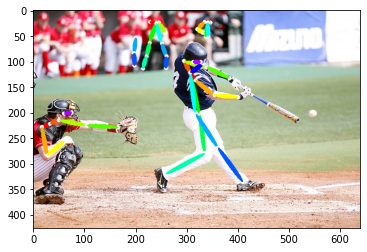

In [27]:
plt.imshow(oriImg)
plt.show()

plt.imshow(result_img)
plt.show()